In [1]:
import gym
import gym_anytrading

from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL
import matplotlib.pyplot as plt
from keras import applications
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, Input, Concatenate, Conv2D
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.agents.ddpg import DDPGAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.random import OrnsteinUhlenbeckProcess
from rl.callbacks import FileLogger, ModelIntervalCheckpoint, TrainIntervalLogger
from rl.processors import WhiteningNormalizerProcessor

from sklearn import preprocessing
import random
import warnings
warnings.filterwarnings('ignore')

import json
import numpy as np

Using TensorFlow backend.
d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\py

In [6]:
class DDPGProcessor(WhiteningNormalizerProcessor):
    def process_action(self, actions):
        return np.random.choice([0,1], p=actions)

class CustomDDPGAgent(DDPGAgent):
    def select_action(self, state):
        eps = 0.1
        if np.random.uniform() < eps:
            return [0.5, 0.5]
        else:
            return super().select_action(state)

        
def env_creator():
    return gym.make('forex-v0', frame_bound=(50, 5000), window_size=10)

env = env_creator()
nb_actions = env.action_space.n

def actorModel():
    # Next, we build a very simple model.
    model = Sequential()
    #model.add(Conv2D(input_shape=(1,10,2), filters=32, kernel_size=(4,2), padding='same'))
    #model.add(Conv2D(filters=64, kernel_size=(4,2), padding='same'))
    #model.add(Conv2D(filters=128, kernel_size=(4,2), padding='same'))
    #model.add(Conv2D(filters=128, kernel_size=(4,2), padding='same'))
    #model.add(Flatten())
    model.add(Flatten(input_shape=(1,10,2)))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(nb_actions, activation='softmax'))
    return model
actorModel().summary()

def criticModel():
    action_input = Input(shape=(2,), name='action_input')
    observation_input = Input(shape=(1,10, 2), name='observation_input')
    flattened_observation = Flatten()(observation_input)
    x = Concatenate()([action_input, flattened_observation])
    x = Dense(1024)(x)
    x = Activation('relu')(x)
    x = Dense(1024)(x)
    x = Activation('relu')(x)
    x = Dense(1024)(x)
    x = Activation('relu')(x)
    x = Dense(1)(x)
    x = Activation('linear')(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return critic, action_input

def agent_creator():
    memory = SequentialMemory(limit=1024, window_length=1)
    processor = DDPGProcessor()
    #processor = WhiteningNormalizerProcessor()
    
    #random_process = OrnsteinUhlenbeckProcess(size=2, theta=.15, mu=0., sigma=.3)
    critic, action_input = criticModel()
    agent = CustomDDPGAgent(nb_actions=2, actor=actorModel(), critic=critic, critic_action_input=action_input,
                      memory=memory, nb_steps_warmup_critic=128, nb_steps_warmup_actor=128, batch_size=64, train_interval=32,
                      random_process=None,processor=processor, gamma=.95, target_model_update=1e-3)
    agent.compile(Adam(lr=.001, clipnorm=1.), metrics=['mae'])
    return agent

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 20)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 1024)              21504     
_________________________________________________________________
dense_26 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_27 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_28 (Dense)             (None, 2)                 2050      
Total params: 2,122,754
Trainable params: 2,122,754
Non-trainable params: 0
_________________________________________________________________


starting train 1
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
150/989 [===>..........................] - ETA: 10s - reward: 0.4047 - cumulative_reward: 19.1387WARNING:tensorflow:From d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\python\ops\math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
989/989 [==============================] - 70s 71ms/step - reward: -20.9046 - cumulative_reward: 862.1839
train 1 completed. took 75.298 seconds, total_reward: 1282.2000000000096 total_profit: 0.8938261673756105
min reward: -141.99999999999991, max reward: 174.09999999999926, mean_reward: 0.2590826429581753


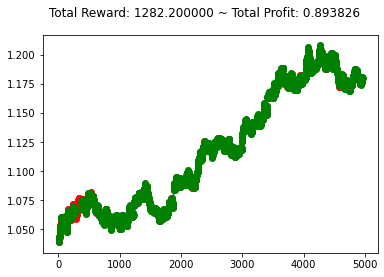

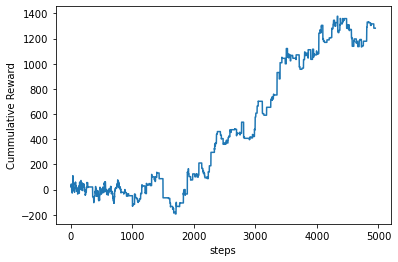

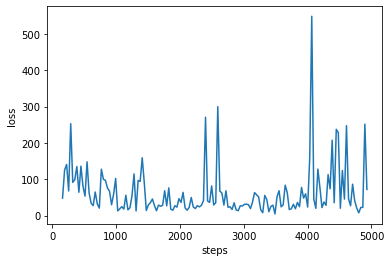

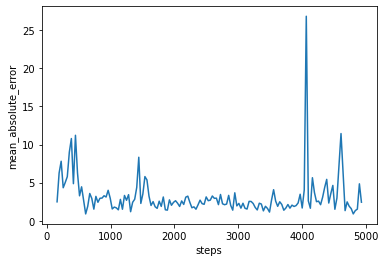

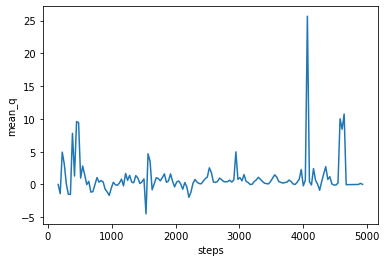

starting train 2
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 71s 72ms/step - reward: -1.4178 - cumulative_reward: -1124.1281
train 2 completed. took 156.339 seconds, total_reward: -1403.3000000000707 total_profit: 0.7584778931828222
min reward: -157.00000000000048, max reward: 122.70000000000003, mean_reward: -0.28355223277431213


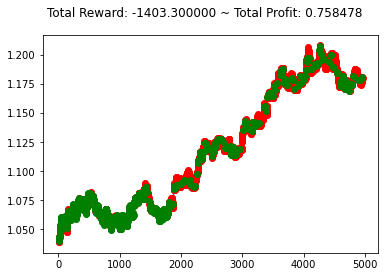

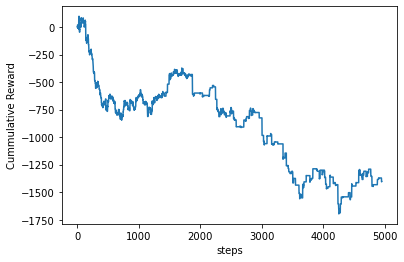

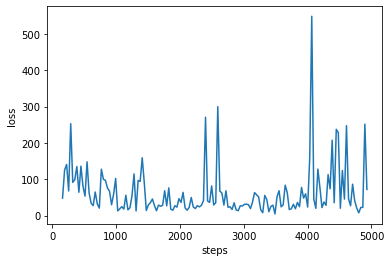

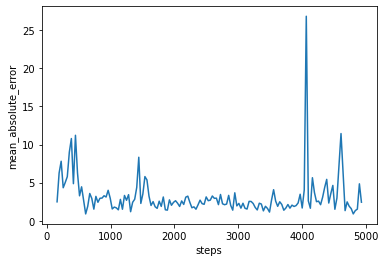

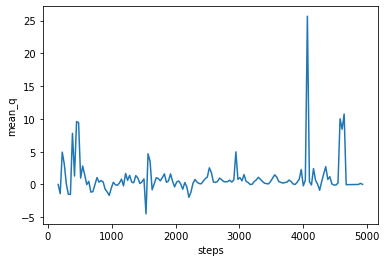

starting train 3
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 69s 70ms/step - reward: -1.3872 - cumulative_reward: -876.1657
train 3 completed. took 236.804 seconds, total_reward: -1373.0999999999503 total_profit: 0.8191872155508396
min reward: -223.00000000000207, max reward: 114.4999999999996, mean_reward: -0.27744998989693886


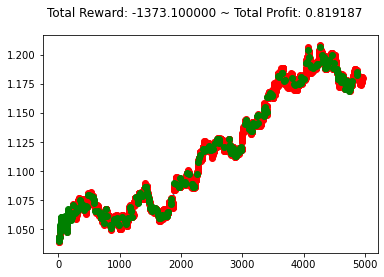

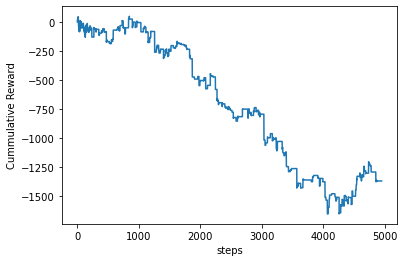

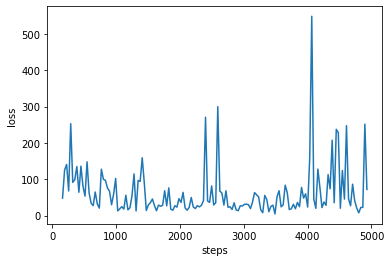

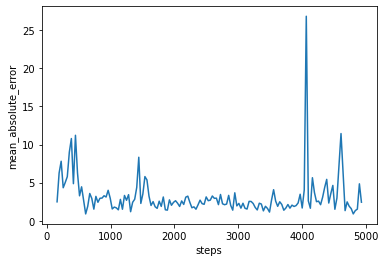

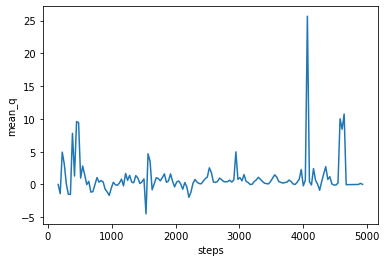

starting train 4
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 71s 71ms/step - reward: 0.4799 - cumulative_reward: 481.0974
train 4 completed. took 319.451 seconds, total_reward: 474.99999999999625 total_profit: 0.88042429565904
min reward: -136.7000000000007, max reward: 180.79999999999873, mean_reward: 0.09597898565366665


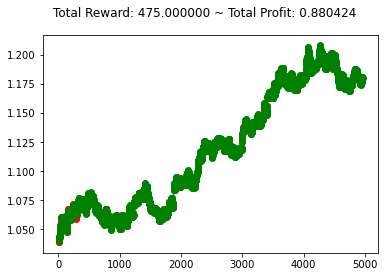

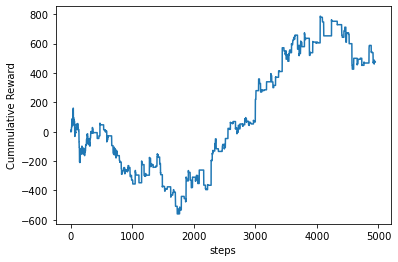

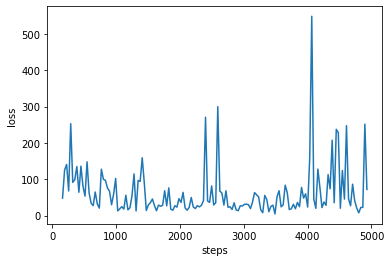

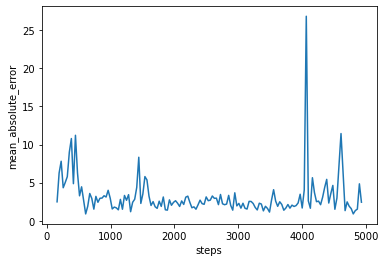

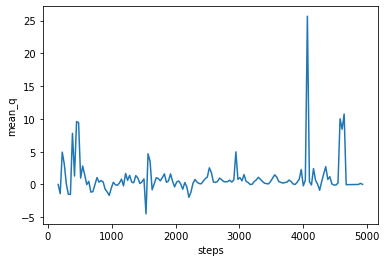

starting train 5
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 75s 76ms/step - reward: 1.0598 - cumulative_reward: 831.9767
train 5 completed. took 407.518 seconds, total_reward: 1049.0000000000389 total_profit: 0.9085468449227734
min reward: -126.59999999999671, max reward: 162.29999999999967, mean_reward: 0.21196201252779126


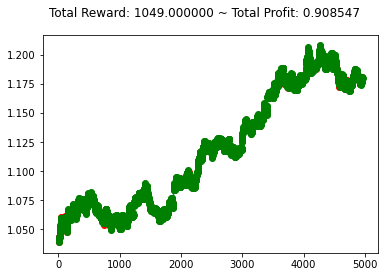

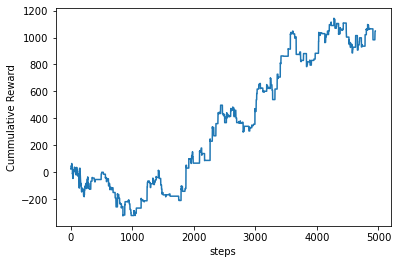

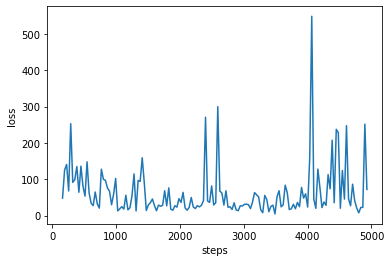

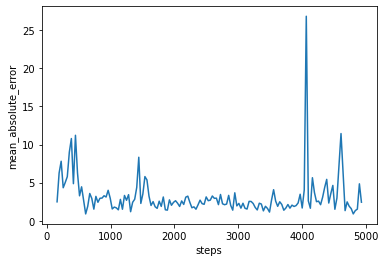

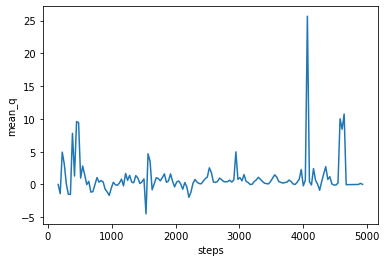

starting train 6
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 74s 75ms/step - reward: -10.5306 - cumulative_reward: 1126.5439
train 6 completed. took 497.237 seconds, total_reward: 1553.4000000000015 total_profit: 0.9290194307652216
min reward: -93.59999999999813, max reward: 189.70000000000152, mean_reward: 0.31388159224085704


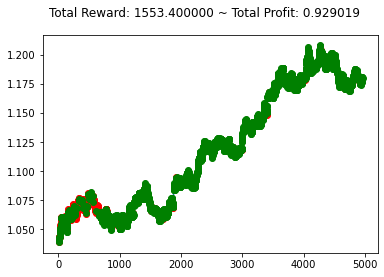

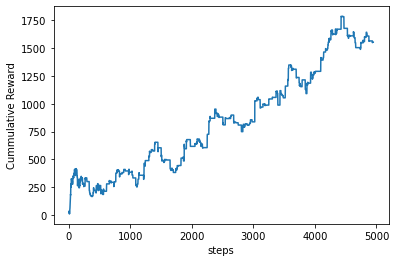

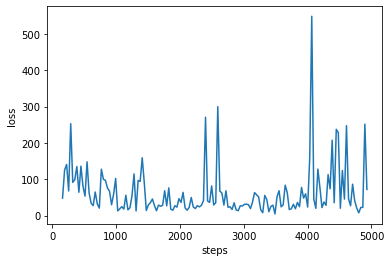

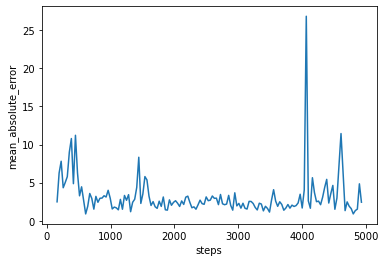

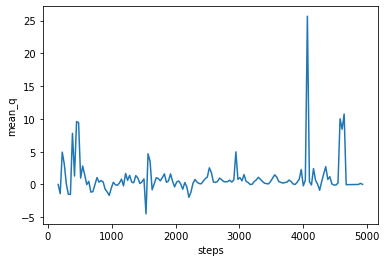

starting train 7
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 80s 81ms/step - reward: -0.1084 - cumulative_reward: -171.6291
train 7 completed. took 594.497 seconds, total_reward: -107.29999999997011 total_profit: 0.8685972667422504
min reward: -177.70000000000064, max reward: 129.89999999999836, mean_reward: -0.021681147706601355


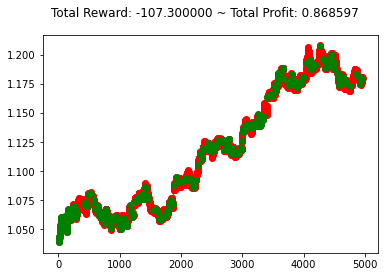

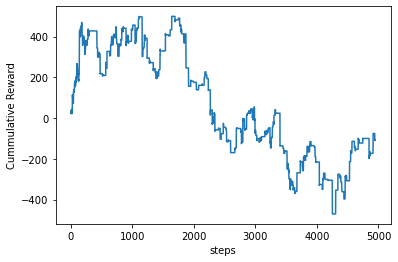

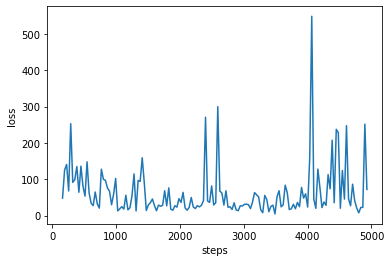

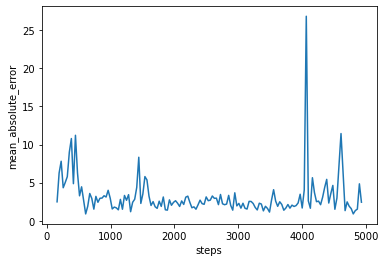

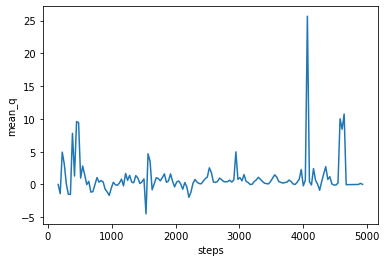

starting train 8
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 83s 84ms/step - reward: 39.0517 - cumulative_reward: 72.6096
train 8 completed. took 698.127 seconds, total_reward: -146.8000000000096 total_profit: 0.8199913483405461
min reward: -125.00000000000178, max reward: 219.10000000000096, mean_reward: -0.029662558092545886


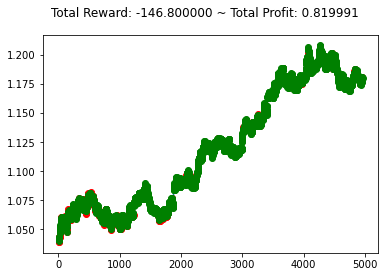

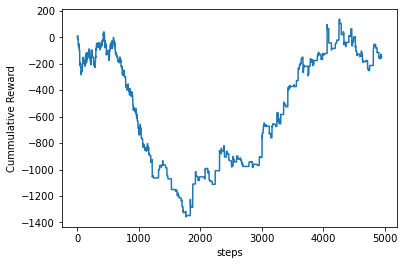

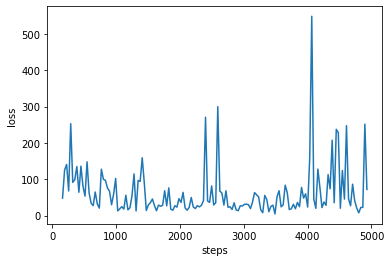

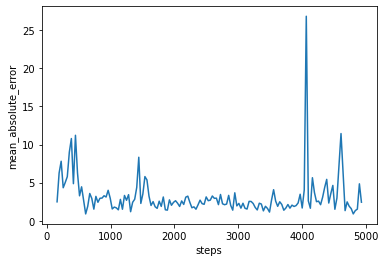

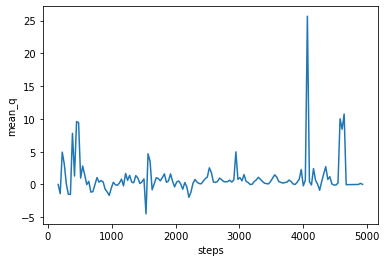

starting train 9
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 90s 91ms/step - reward: 8.9258 - cumulative_reward: -263.2984
train 9 completed. took 807.408 seconds, total_reward: -469.39999999997485 total_profit: 0.8550303600563863
min reward: -160.70000000000027, max reward: 126.40000000000207, mean_reward: -0.0948474439280612


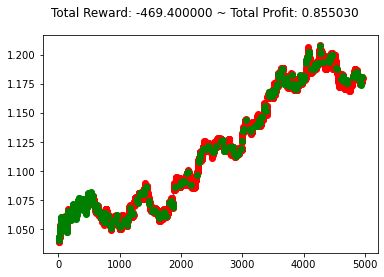

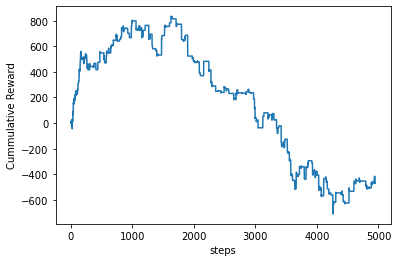

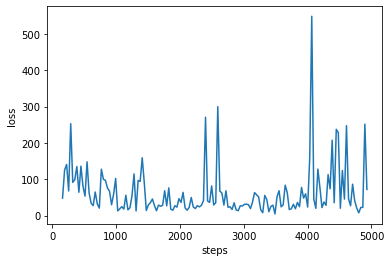

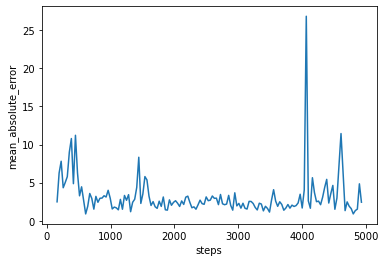

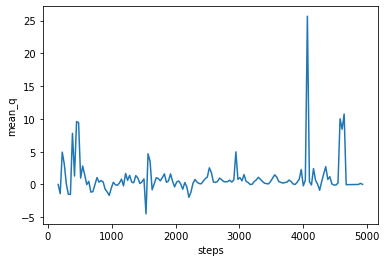

starting train 10
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 84s 84ms/step - reward: -1.6397 - cumulative_reward: -1069.2583
train 10 completed. took 912.458 seconds, total_reward: -1623.0000000000052 total_profit: 0.8075027389501546
min reward: -167.60000000000107, max reward: 141.5999999999995, mean_reward: -0.32794503940190045


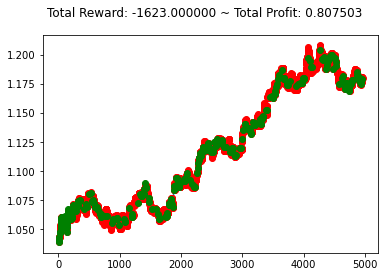

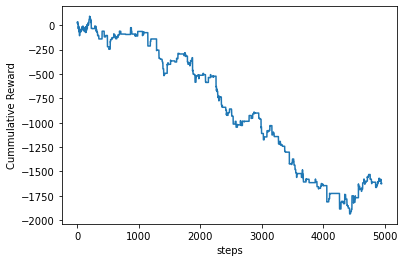

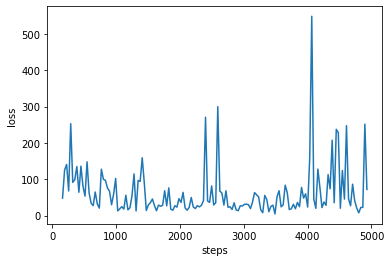

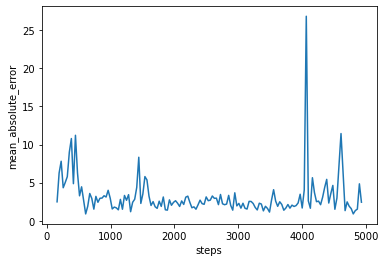

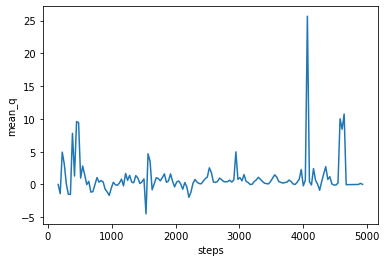

In [7]:
from evaluator import Evaluator

e = Evaluator(agent_creator, env_creator, name="ddpg")
e.train(repeat=10)


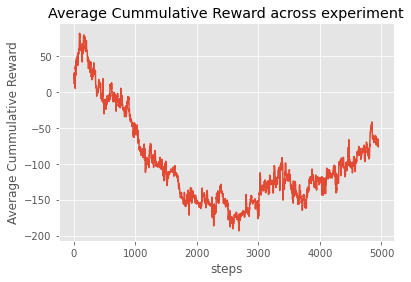

In [8]:
e.process_train_result()

Testing for 1 episodes ...
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
192/199 [===========================>..] - ETA: 0s - reward: -0.5674 - cumulative_reward: -130.5142Episode 1: reward: -151.100, steps: 999

test completed. total_reward: -151.10000000000616 total_profit: 0.9834859945776661
min reward: -135.20000000000198, max reward: 105.1000000000002, mean_reward: -0.1512512512512574



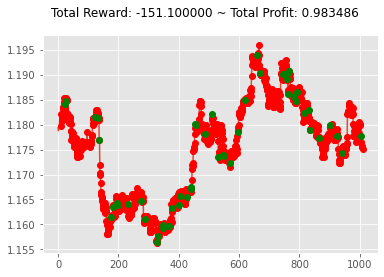

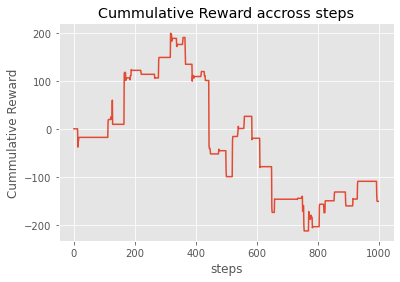

In [9]:
e.test(gym.make('forex-v0', frame_bound=(5000, 6000), window_size=10))